# Introduction to UMAP

We have already been introduced to the concept of dimensionality reduction in PCA, but in this module we will explore one more powerful technique for dimensionality reduction and data visualization: Uniform Manifold Approximation and Projection (UMAP). This method, like PCA, is particularly useful for visualizing high-dimensional data in a low-dimensional space, making them ideal for biological datasets such as gene expression profiles or protein interaction networks. However, unlike PCA, these methods are not "linearly constrained" the way PCA is and can help uncover hidden structures in your data.

By the end of this module, you will be able to:

- Understand the basic principles behind  UMAP  (Uniform Manifold Approximation and Projection).
- Apply UMAP to biological data using Python.
- Understand the different parameters of UMAP and how they impact the end visualization.

## Setup

Before we start, ensure you have all the necessary libraries installed. Run the following commands to install UMAP, scanpy, python-igraph, and louvain:


In [ ]:
%%capture
!pip install umap-learn scanpy python-igraph louvain

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
import scanpy as sc
import matplotlib as mpl
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

## Linear and Non-Linear Data
Before we dive into UMAP and other methods of dimension reduction, let's explore what it means for a dataset to be "non-linear". Lets consider the following dataset: the Swiss Roll.

In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets, manifold
sr_points, sr_color = datasets.make_swiss_roll(n_samples=1500, random_state=0, hole= True)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    sr_points[:, 0], sr_points[:, 1], sr_points[:, 2], c=sr_color, s=50, alpha=0.8
)
ax.set_title("Swiss Roll")
ax.view_init(azim=-66, elev=12)
_ = ax.text2D(0.8, 0.05, s="n_samples=1500", transform=ax.transAxes)

This dataset consists of a "sheet" of points with a hole in it has have been rolled up. The datasets have been colored by their position in the sheet. We can see that one side of the sheet is colored dark blue while the other side is colored light green.  

Now theres one key question we can ask: How does the color vary with respect to the axis? Well thats a tough question. Unlike other datasets where we might be able to say "the color becomes lighter as X1 increases" or "as X_1 and X_2 increase, the color becomes darker," the trend here is more complex. More formally, we cannot represent the structure of the data with a simpled weighted combinations of the features of the data.


This means that *Linear* feature reduction methods of dimensionality reduction, such as PCA, will not be able to accurately capture the structure of the data. To see this first handle, lets quickly run PCA below:

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sr_points)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c = sr_color)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Swiss Roll w/ Hole Dataset')
plt.show()

As you can see, the fact that the data is a rolled up sheet is completely destroyed when looking at the PCA visualization. Additionally, the fact that there is a hole in the roll is completely missed.

So whats the alternative? Well, we should use *Non-Linear* dimensionality reduction methods, such as UMAP.

We can see here that the structure of the data is better captured here (albeit with some warping) than in the PCA. We can clearly see that the points form a clear sheet and we can see the hole in the roll.

In [ ]:
from umap import UMAP
umap = UMAP(n_components=2, n_neighbors=25, min_dist=0.5, random_state=0)
umap_result = umap.fit_transform(sr_points)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c = sr_color)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP of Swiss Roll w/ Hole Dataset')
plt.show()

## Understanding Single-cell vs. Bulk Data
Now lets demonstrate how these two methods work on real world datasets, specifically in RNA sequencing.

In traditional bulk RNA sequencing, we analyze the average gene expression of a sample containing thousands or millions of cells. This method gives us a broad overview, useful for identifying general trends and patterns. However, it blends the contributions of distinct cell types and states into a single, averaged signal. In contrast, single-cell RNA sequencing (scRNA-seq) allows us to examine the transcriptome at the individual cell level, uncovering the diversity hidden within tissues.
Why Single-cell?

### Single-cell sequencing illuminates:

- Cellular heterogeneity: Discover the variety of cell types and states within a sample.
- Developmental pathways: Trace the lineage and differentiation pathways of stem cells.
- Disease mechanisms: Identify the cellular basis of diseases by pinpointing aberrant cells or pathways.



## Analyzing Single-cell Data



A typical scRNA-seq dataset includes:

- Thousands of cells (observations).
- Gene expression levels across thousands of genes (features).

This results in a high-dimensional matrix, where each cell's gene expression profile is a point in this vast space.

We will be retrieving the scRNA-seq data from `scanpy`, a toolkit for analyzing single-cell gene expression data. Specifically, we will be working with the `pbmc3k` dataset, which is a single-cell RNA sequencing (scRNA-seq) dataset made publicly available by 10x Genomics. It consists of roughly 3,000 Peripheral Blood Mononuclear Cells (PBMCs) from a healthy donor.

PBMCs are a diverse mixture of blood cells, including lymphocytes (T cells, B cells, NK cells), monocytes, and dendritic cells, each playing a crucial role in the immune system. This dataset is often used as a benchmark in scRNA-seq data analysis because it encompasses a variety of cell types, making it ideal for exploring dimensionality reduction techniques and clustering algorithms.

(The data is freely available from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)).


One of the main goals of single-cell data analysis is identifying distinct groups of cells that share similar expression patterns. This process, known as clustering, helps to reveal the underlying cellular heterogeneity within a sample. One of the most widely used clustering methods in scRNA-seq data analysis is the Louvain algorithm.

Louvain clustering is a method used to group single cells based on their gene expression profiles. In a dataset of scRNA-seq, each cell can be expressed as a point in a high-dimensional space, where each dimension corresponds to the expression level of a gene. Cells that are similar to each other in terms of gene expression are closer in this space. Louvain clustering works by finding these groups of closely related cells, effectively identifying cells that share similar expression patterns, which often correspond to the same cell type or cells in the same state.

In the cell below, we pull the relevant data and perform Louvain clustering. We save the data and the clusters each sample is in into `data` and `clusters` respectively.


In [ ]:
adata = sc.datasets.pbmc3k()
sc.pp.recipe_zheng17(adata, n_top_genes=1000, log=True, plot=False, copy=False)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, use_rep='X_pca')
# Louvain clustering
sc.tl.louvain(adata)
data = adata.X
clusters = adata.obs['louvain']
print(data.shape, clusters.shape)

---
###### **Q1: In the cell below, identify how many groups Louvain discovered.**


---

### PCA
Now that we have our groups, lets try and visualize the data with the tools we have. To do this, lets reduce the dimensionality of our data set to 2 so we can visualize it.  

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

Now, lets plot the reduced dataset and color the points based on the cluster the point is in.

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters.astype('category').cat.codes)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of pbmc3k Dataset')
plt.colorbar()
plt.show()

As you can see, the PCA plot is not very informative. As we said before, this is primarily because PCA is a **linear** dimensionality reduction technique that projects data onto axes that capture the most variance. If the dataset's underlying structure is non-linear, which is often the case in biological data, PCA might not effectively reveal the inherent clusters. To confirm this, we need to check the explained variance of the components.



---
###### **Q2: In the cell below, print the the explained variance of the two components. What does the explained variance of these components indicate about the usefulness of the PCA visualization?**


Your Answer Here

---

### UMAP
As we can see above, the components obtained via PCA can be uninformative and we often need **non-linear** methods of dimension reduction. One state-of-the-art algorithm for this task is Uniform Manifold Approximation and Projection (UMAP). UMAP and methods like it operate on a simple intuition: points that are similar to each other in the original space should be close to each other in the reduced space, and dissimilar points should be far from each other. To achieve this, UMAP attempts to learn a "manifold", or a non-linear multi-dimensional plane, that most of the points are close to. You can read about the specifics of how UMAP accomplishes this in the [original paper](https://arxiv.org/abs/1802.03426).

Lets try plotting our points using UMAP and seeing the difference between the UMAP visualization and the PCA output.

To do this, we will:
1. First fit a PCA with a large number of components to reduce noise (we choose 50)
2. Then fit a UMAP model on the PCA result using the implementation provided in the `umap` package. This implementation can be used exactly like models in `sklearn`.

In [ ]:
from umap import UMAP
## Fit a PCA model
pca = PCA(n_components=50)
pca_result = pca.fit_transform(data)

## Fit the UMAP
umap = UMAP(n_components=2, n_neighbors=30, min_dist = 0.5)
umap_result = umap.fit_transform(pca_result)

## Plot the UMAP Results
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=clusters.astype('category').cat.codes)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP of pbmc3k Dataset')
plt.colorbar()
plt.show()

#### UMAP Parameters

Let's explore how we generate a UMAP Visualization:



```
umap = UMAP(n_components=2, n_neighbors=30, min_dist = 0.5)
```
The first parameter we need to choose is the **number of nearest neighbors** to consider (`n_neighbors`). This parameter controls how UMAP balances *local* structures versus *global structures.* Like we mentioned before, UMAP operates on the intuition that similar points in the high-dimensional space should be similar in low dimensional space. With a small `n_neighbors` value, UMAP will compare each point to a small number of points, making it focus on more fine-grained structures in the data. With a large `n_neighbors` value, UMAP will look at a larger number of neighbors to each point, making the algorithm focus on broader structures in the data, sacrificing the detailed structures of the data.





---
###### **Q3: Try Running UMAP with two different nearest neighbor values  values and describe how the visualizations differ.**

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

Your Answer Here

---

The other parameter we need to choose is **minimum distance** (`min_dist`). The `min_dist` parameter specifies the mininum distance apart that points are allowed to be in the low dimensional representation. Low values of `min_dist`will result in clumpier embeddings, while larger values will result in more spread out embeddings. Low `min_dist` values may be useful for certain clustering tasks, while large `min_dist` preserve large topological structures in the data.  


---
###### **Q4: Try Running UMAP with two different min_dist values and describe how the visualizations differ.**

In [ ]:
## Your Code Here

In [ ]:
## Your Code Here

Your Answer Here

---

## Conclusion

In this module, we've explored UMAP (Uniform Manifold Approximation and Projection), a powerful and flexible tool for dimensionality reduction and data visualization. By understanding the underlying principles and key parameters of UMAP, you're now equipped to apply this technique to complex datasets, uncovering patterns and structures that might otherwise remain hidden.

UMAP's ability to maintain the global structure of data while preserving local relationships makes it a valuable asset in various problems. As you continue to experiment with UMAP, remember to fine-tune parameters like `n_neighbors` and `min_dist` based on your specific data and analysis goals. This adaptability ensures that UMAP can be tailored to meet the needs of diverse projects.

Whether you're using UMAP for exploratory data analysis, clustering, or as a preprocessing step for machine learning models, its efficiency and effectiveness can significantly enhance your analytical capabilities. Keep experimenting, and you'll discover just how transformative UMAP can be in extracting meaningful insights from high-dimensional data.

# Graded Questions

---
##### **GQ1: In the two cells below, we have visualized the two different datasets. Which one is a linear dataset, and which is not? Justify your answer.**


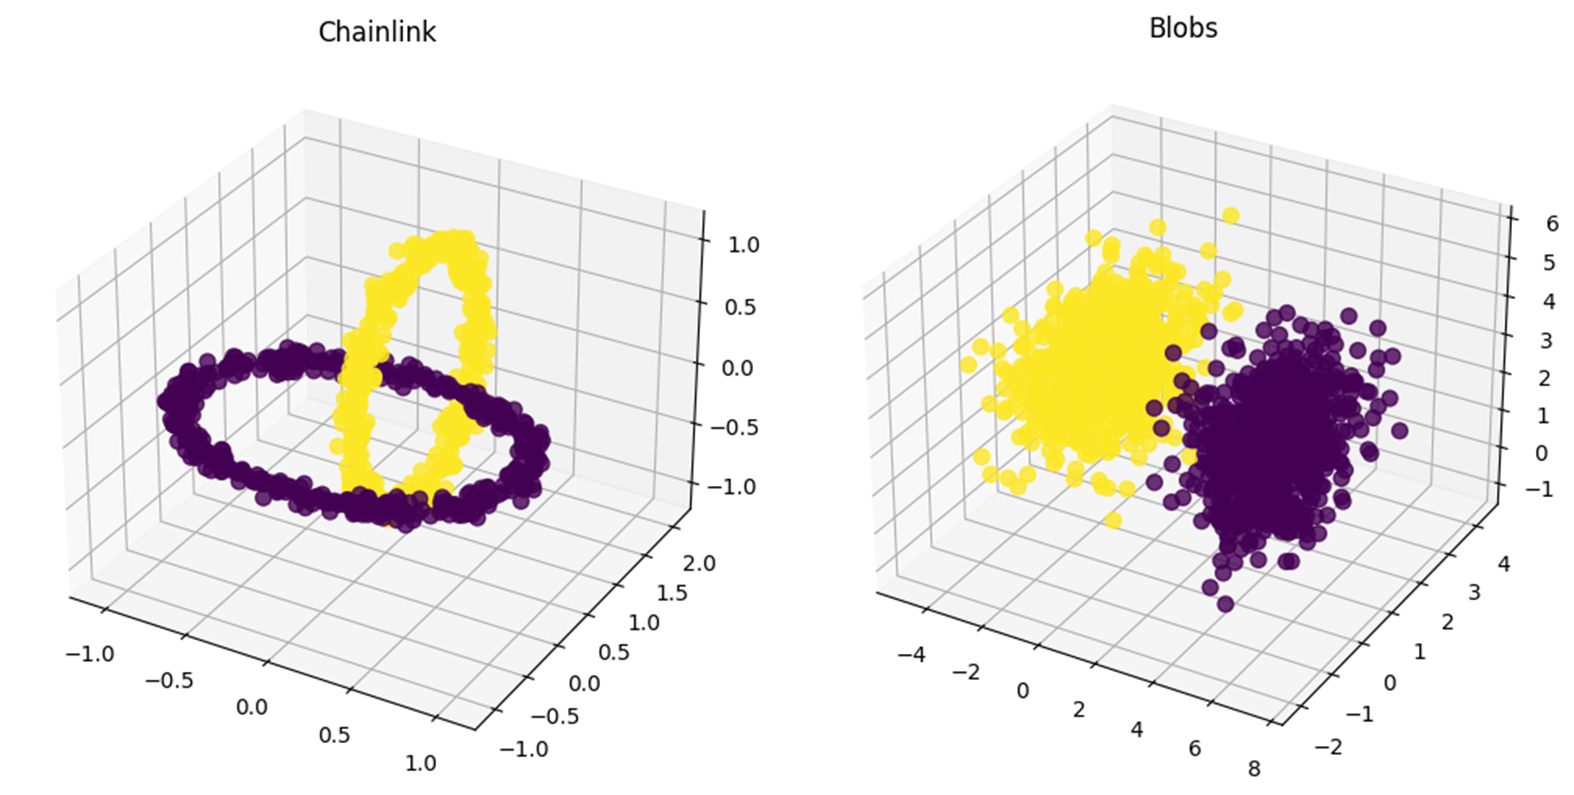

Your Answer Here

---
##### **GQ2: UMAP Parameter Visualization**
> In the code below, we have provided skeleton code to visualize different parameter values of UMAP in an interactive widget. Fill in the relevant code blocks to complete the visualization code and run the cell.

In [ ]:
%pip install -q ipywidgets

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
minimum_min_dist_value = # your code here
maximum_min_dist_value =  # your code here
min_dist_step =  # your code here
minimum_n_neighbors_value = # your code here
maximum_n_neighbors_value =  # your code here
n_neighbors_step = # your code here

min_dists = np.arange(minimum_min_dist_value, maximum_min_dist_value, min_dist_step)
n_neighbors = range(minimum_n_neighbors_value, maximum_n_neighbors_value, n_neighbors_step)

# store UMAP results for each parameter combination
umap_results = {}
for min_dist in min_dists:
    for n_neighbor in n_neighbors:
        # TODO: write code to do obtain the UMAP embeddings.
        #       Remember to fit your UMAP on the pca_result NOT the original data.
        umap_result =
        key = (min_dist, n_neighbor)
        umap_results[key] = umap_result  # Storing a copy of the UMAP results

In [ ]:

# plot for visualization
fig, ax = plt.subplots(figsize=(8, 6))

def update_plot(min_dist, n_neighbors):
    """
    Update the plot based on the selected min_dist and n_neighbors.
    """
    ax.clear()  # clear the plot
    key = (min_dist, n_neighbors)

    X_umap_ = umap_results[key]
    color_codes = clusters.astype('category').cat.codes
    # TODO: Create a scatter plot of the UMAP visualization and color it by the
    #       Louvain clusters. Make sure you also update the plot title.
    ax.grid(True)
    plt.show()

# widgets for selecting min_dist and n_neighbors
min_dist_slider = widgets.FloatSlider(value=minimum_min_dist_value,
                                      min=minimum_min_dist_value,
                                      max=maximum_min_dist_value,
                                      step=min_dist_step,
                                      description='Min Dist:')
n_neighbors_slider = widgets.IntSlider(value=minimum_n_neighbors_value,
                                       min=minimum_n_neighbors_value,
                                       max=maximum_n_neighbors_value,
                                       step=n_neighbors_step,
                                       description='Neighbors:')
ui = widgets.VBox([min_dist_slider, n_neighbors_slider])

# widget
out = widgets.interactive_output(update_plot, {'min_dist': min_dist_slider, 'n_neighbors': n_neighbors_slider})

# interactive controls and plot
display(ui, out)

---
##### **GQ3: Play with the different combinations of n_neighbors and min_dist. How does the visualization look when both the min_dist and n_neighbors are high in contrast to when both are low? How about when min_dist is high and n_neighbors is low and the opposite? Which, from the four combinations you tried, provides the clearest visualization of the separation between clusters?**

Your Answer here

---
